In [283]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import torchvision
import matplotlib.pypot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [6]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.data = []
        self.labels = []
        self.classes = ['dogs', 'food', 'vehicles']
        
        for class_id, class_name in enumerate(self.classes):
            class_path = os.path.join(self.data_dir, class_name)
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                img = Image.open(file_path).convert('RGB')
                self.data.append(img)
                self.labels.append(class_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, label = self.data[index], self.labels[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

# Define your transformation function
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load your data using the DataLoader class from PyTorch
dataset = CustomDataset('cnn_dataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)




In [7]:
dataset.classes

['dogs', 'food', 'vehicles']

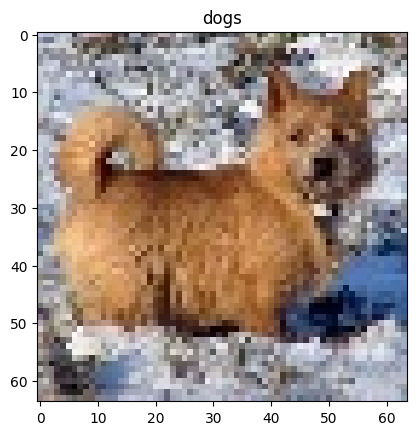

In [295]:
import matplotlib.pyplot as plt

# Get the first image and label from the dataset
img, label = dataset[0]

# Convert the tensor to a numpy array
img = img.numpy()

# Transpose the image from (C, H, W) to (H, W, C) format
img = img.transpose(1, 2, 0)

# Denormalize the image
img = img * 0.5 + 0.5

# Print the image and label
plt.imshow(img)
plt.title(dataset.classes[label])
plt.show()


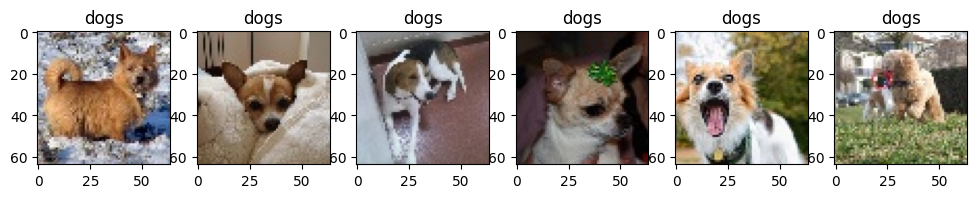

In [297]:
images,labels=zip(*[dataset[i] for i in range(6)])
images = [(img.numpy().transpose(1,2,0)*0.5+0.5) for img in images]
#going tio use subplot for multiple images
fig,axis = plt.subplots(1,6,figsize=(12,3))
for i, (img, label) in enumerate(zip(images,labels)):
    axis[i].imshow(img)
    axis[i].set_title(dataset.classes[label])
plt.show()


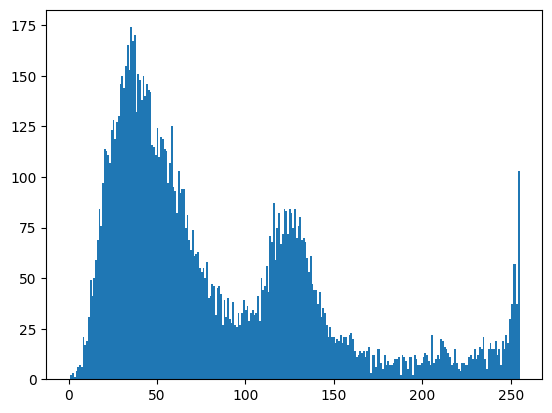

In [294]:
image_path="cnn_dataset/dogs/1.jpg"
image= Image.open(image_path)

arr_image=np.array(image)
plt.hist(arr_image.ravel(), bins=256, range=(0,255))
plt.show()

In [290]:
print(dataset[0][1])

0


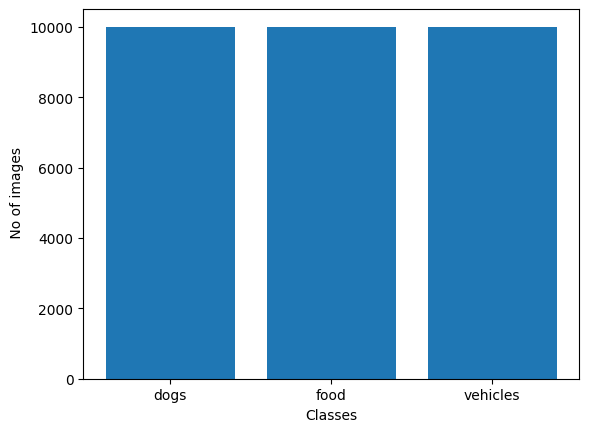

In [292]:
list_count=[0,0,0]
for i in dataset:
    for j in range(0,3):
        if i[1]==j:
            list_count[j]+=1
            

                
plt.bar(dataset.classes,list_count)
plt.xlabel("Classes")
plt.ylabel(" No of images")
plt.show()
            

In [8]:
len(dataset)

30000

In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, x_test= train_test_split(dataset, test_size=0.2, random_state=42)


In [10]:
len(X_train)

24000

In [11]:
len(x_test)

6000

In [12]:
train_dataloader = DataLoader(X_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(x_test, batch_size=32, shuffle=False)


In [14]:

# Define the AlexNet architecture
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [15]:
model = AlexNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
num_epochs=10

In [32]:
#X_train, X_test, y_train, y_test
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device) , data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / len(X_train)))

            

[1,   938] loss: 0.015
[2,   938] loss: 0.014
[3,   938] loss: 0.013
[4,   938] loss: 0.012
[5,   938] loss: 0.012
[6,   938] loss: 0.011
[7,   938] loss: 0.011
[8,   938] loss: 0.011
[9,   938] loss: 0.011
[10,   938] loss: 0.010


In [298]:
train_Acc=(1-0.010)*100
train_Acc

99.0

In [33]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # compute training loss and accuracy
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == targets.data)

    train_loss /= len(train_loader.dataset)
    train_acc = 100.0 * train_acc / len(train_loader.dataset)

    return train_loss, train_acc


In [36]:
# Evaluate the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test set: %d %%' % (100 * correct / total))


Accuracy on the test set: 87 %


In [301]:
test_Acc
print(train_Acc)
print(test_Acc)

99.0
87


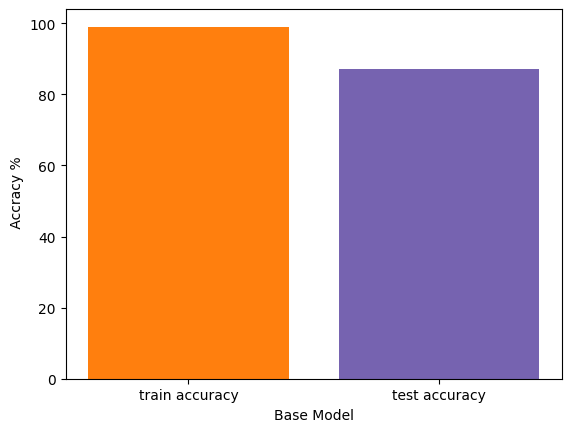

In [304]:
plt.bar(['train accuracy','test accuracy'],[train_Acc,test_Acc],color=['#ff7f0e', '#7663b0'])
plt.xlabel("Base Model")
plt.ylabel(" Accracy %")
plt.show()

In [ ]:
#changing hyperparameters

In [37]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=11, stride=4, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(1),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [38]:
learning_rate = 0.001
num_epochs = 11
batch_size = 64

In [42]:
for epoch in range(num_epochs):
    for images, labels in train_dataloader:
        # Clear gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Calculate loss
        loss = nn.CrossEntropyLoss()(outputs, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()
    
    # Calculate accuracy on validation set
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Print epoch number and accuracy
    print(f'Epoch {epoch+1}: Val Accuracy = {100 * correct / total:.2f}%')

Epoch 1: Val Accuracy = 89.71%
Epoch 2: Val Accuracy = 89.70%
Epoch 3: Val Accuracy = 89.72%
Epoch 4: Val Accuracy = 89.04%
Epoch 5: Val Accuracy = 89.41%
Epoch 6: Val Accuracy = 89.96%
Epoch 7: Val Accuracy = 90.70%
Epoch 8: Val Accuracy = 90.61%
Epoch 9: Val Accuracy = 91.38%
Epoch 10: Val Accuracy = 91.19%
Epoch 11: Val Accuracy = 91.28%


In [ ]:
#implemnting batch normlaization

In [46]:
class ModifiedAlexNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ModifiedAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [47]:
# Initialize the model
model = ModifiedAlexNet(num_classes=5).to(device)

In [48]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [17]:
# Early stopping
best_acc = 0.0
patience = 3
early_stop = False
epoch = 0

while not early_stop:
    epoch += 1
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch, i + 1, running_loss / 100))
            running_loss = 0.0

    # Evaluate the performance of the model on the validation data
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    val_acc = correct / total
    print('Accuracy of the network on the validation images:',val_acc)
    if val_acc > best_acc:
        best_acc = val_acc
#         best_model = copy.deepcopy(model.state_dict())
        patience = 3
    else:
        patience -= 1

    # Check if early stopping criteria are met
    if patience == 0:
        early_stop = True
        print("Early stopping. Best validation accuracy:", best_acc)    

[1,   100] loss: 0.452
[1,   200] loss: 0.453
[1,   300] loss: 0.425
[1,   400] loss: 0.412
[1,   500] loss: 0.400
[1,   600] loss: 0.393
[1,   700] loss: 0.409
Accuracy of the network on the validation images: 0.8648333333333333
[2,   100] loss: 0.364
[2,   200] loss: 0.374
[2,   300] loss: 0.393
[2,   400] loss: 0.388
[2,   500] loss: 0.375
[2,   600] loss: 0.381
[2,   700] loss: 0.383
Accuracy of the network on the validation images: 0.8555
[3,   100] loss: 0.334
[3,   200] loss: 0.342
[3,   300] loss: 0.329
[3,   400] loss: 0.360
[3,   500] loss: 0.317
[3,   600] loss: 0.357
[3,   700] loss: 0.343
Accuracy of the network on the validation images: 0.8656666666666667
[4,   100] loss: 0.338
[4,   200] loss: 0.361
[4,   300] loss: 0.306
[4,   400] loss: 0.320
[4,   500] loss: 0.324
[4,   600] loss: 0.329
[4,   700] loss: 0.332
Accuracy of the network on the validation images: 0.8795
[5,   100] loss: 0.292
[5,   200] loss: 0.302
[5,   300] loss: 0.387
[5,   400] loss: 0.349
[5,   500] l

In [280]:
var1=91.28
var=93.51

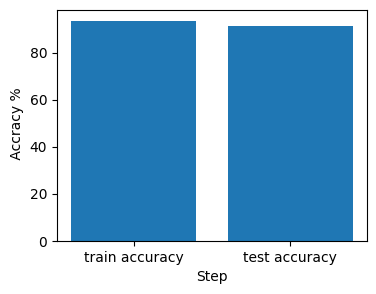

In [311]:
fig = plt.figure(figsize=(4, 3))
plt.bar(['train accuracy','test accuracy'],[var,var1])
plt.xlabel("Step")
plt.ylabel(" Accracy %")
plt.show()

In [101]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image


In [55]:
import torchvision
import torchvision.transforms as transforms

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load training set
train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)

# Load testing set
test_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)


Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


[4948, 13861, 10585, 8497, 7458, 6882, 5727, 5595, 5045, 4659]


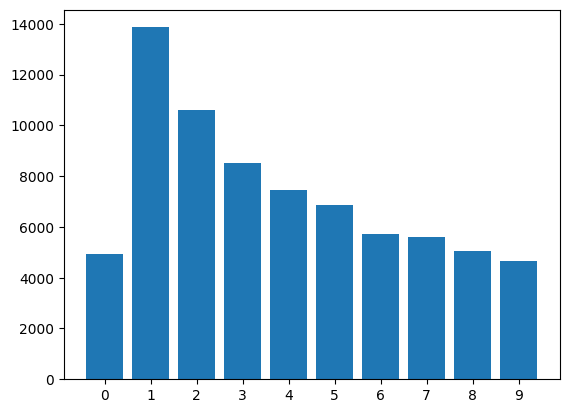

In [108]:
list_count = [0,0,0,0,0,0,0,0,0,0]
for i in train_dataset:
    for j in range(0,10):
        if j == i[1]:
            list_count[j] += 1
print(list_count)
        
plt.bar(["0","1","2","3","4","5","6","7","8","9"],list_count)
plt.show()

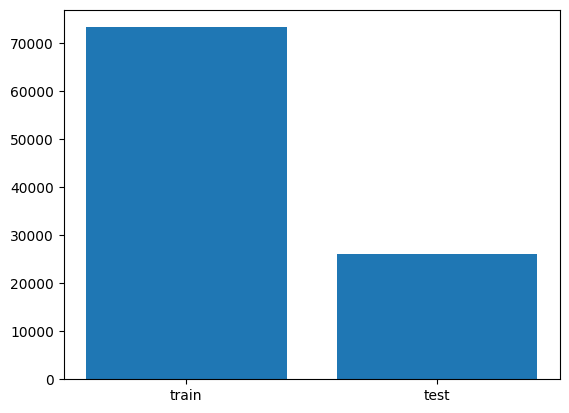

In [103]:
total_images=[len(train_dataset),len(test_dataset)]
plt.bar(["train","test"],total_images)
plt.show()

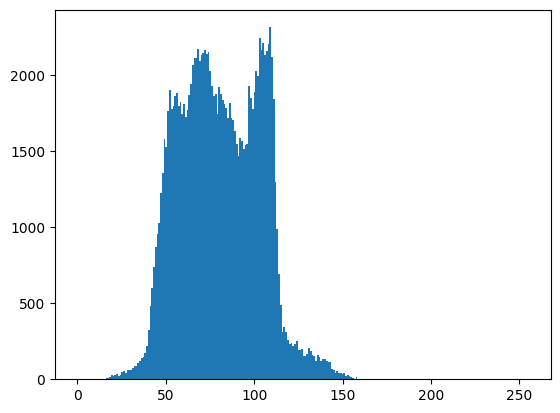

In [102]:
image_path="10010.png"
image= Image.open(image_path)

arr_image=np.array(image)
plt.hist(arr_image.ravel(), bins=256, range=(0,255))
plt.show()

In [56]:
len(train_dataset)

73257

In [57]:
len(test_dataset)

26032

In [58]:
import torch.utils.data as data

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [59]:
#transform
#transform = transforms.Compose([
#    transforms.Resize((32, 32)),
#    transforms.ToTensor(),
#    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#])
transform = transforms.Compose([

    transforms.RandomCrop(size=(32, 32)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=63./255., saturation=[0.5, 1.5], contrast=[0.2, 1.8]),
    transforms.ToTensor(),
    transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))
    ])

In [60]:
#augmenting
aug_train_data = torchvision.datasets.SVHN('SVHN', split='train', transform=transform, download=True)

aug_test_data = torchvision.datasets.SVHN('SVHN', split='test', transform=transform, download=True)

Using downloaded and verified file: SVHN/train_32x32.mat
Using downloaded and verified file: SVHN/test_32x32.mat


In [61]:
from torch.utils.data import ConcatDataset

# Concatenate the original training set and the augmented training set
concat_train_dataset = ConcatDataset([train_dataset, aug_train_data])
# Concatenate the original testing set and the augmented testing set
concat_test_dataset = ConcatDataset([test_dataset, aug_test_data])


In [62]:
len(concat_train_dataset)

146514

In [63]:
len(concat_test_dataset)

52064

In [64]:
# Create a DataLoader for the concatenated training set
train_loader = torch.utils.data.DataLoader(concat_train_dataset, batch_size=32, shuffle=True)
# Create a DataLoader for the concatenated testing set
train_loader = torch.utils.data.DataLoader(concat_train_dataset, batch_size=32, shuffle=True)


In [65]:
class ModifiedAlexNet(nn.Module):
    def __init__(self, num_classes: int = 10):
        super(ModifiedAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [66]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [67]:
# Initialize the model
model = ModifiedAlexNet(num_classes=10).to(device)

In [68]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [78]:
# Training the model and finding the training loss.
train_loss_SVHN = []
for count in range(num_epochs):
    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss_SVHN.append(train_loss/len(train_loader))
    print ('Epoch [{} of {}], Training Loss: {:.4f}' .format(count+1,num_epochs,train_loss/len(train_loader))) 

Epoch [1 of 10], Training Loss: 1.6730
Epoch [2 of 10], Training Loss: 1.2363
Epoch [3 of 10], Training Loss: 1.1413
Epoch [4 of 10], Training Loss: 1.0656
Epoch [5 of 10], Training Loss: 1.0243
Epoch [6 of 10], Training Loss: 0.0930
Epoch [7 of 10], Training Loss: 0.0643
Epoch [8 of 10], Training Loss: 0.0420
Epoch [9 of 10], Training Loss: 0.0373
Epoch [10 of 10], Training Loss: 0.0119


In [79]:
# Calculating testing accuracy
SVHN_test_accuracy= []
for count in range(num_epochs):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        SVHN_test_accuracy.append(100 * correct / total)
    testing_accuracy = 100 * correct / total

In [83]:
testing_accuracy

82.5874


In [91]:
var1=testing_accuracy

In [84]:
var=(1-0.0119)*100

In [92]:
var1

82.5874

In [87]:
var

98.81

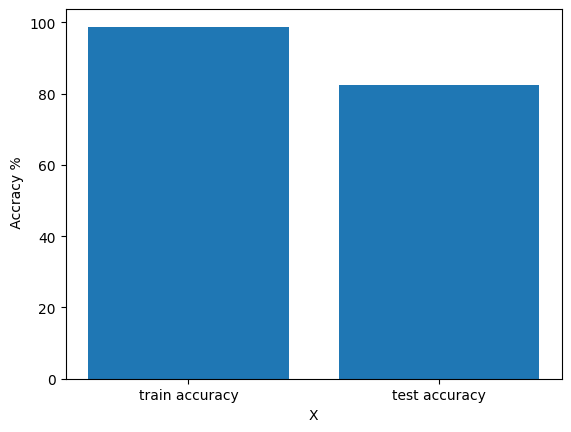

In [109]:
plt.bar(['train accuracy','test accuracy'],[var,var1])
plt.xlabel("X")
plt.ylabel(" Accracy %")
plt.show()